## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [12]:
import yfinance as yf
print("yfinance instalado correctamente")


yfinance instalado correctamente


1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [13]:
bcrp_url = ("https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api")

print(bcrp_url)

https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [20]:
from pathlib import Path
import hashlib
import re
import warnings
from typing import Optional, Union, List, Dict, Any

import numpy as np
import pandas as pd

# -----------------------
# Basic setup + caching
# -----------------------
CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)
warnings.filterwarnings("ignore")

_ES_TO_EN_MONTH = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

def _hash_key(*parts: str) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _normalize_period(code: str, period: Optional[str]) -> Optional[str]:
    if period is None:
        return None
    period = str(period).strip()
    freq = code[-2:].upper() if len(code) >= 2 else ""

    if freq == "PD":  # daily
        if re.fullmatch(r"\d{4}-\d{1,2}", period):
            y, m = period.split("-")
            return f"{int(y):04d}-{int(m):02d}-01"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-01-01"
        return period

    if freq == "PM":  # monthly
        m = re.fullmatch(r"(\d{4})-(\d{1,2})-(\d{1,2})", period)
        if m:
            y, mo, _ = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        m = re.fullmatch(r"(\d{4})-(\d{1,2})", period)
        if m:
            y, mo = m.groups()
            return f"{int(y):04d}-{int(mo)}"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-1"
        return period

    if freq == "MD":  # daily index
        return period

    return period

def _parse_bcrp_period_name(name: str) -> pd.Timestamp:
    s = str(name).strip()

    # ISO-ish
    try:
        if re.fullmatch(r"\d{4}(-\d{1,2}){0,2}", s):
            return pd.to_datetime(s, errors="raise")
    except Exception:
        pass

    # Monthly like "Mar.2020"
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.(\d{4})", s)
    if m:
        mon_es, y = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        return pd.to_datetime(f"{mon}.{y}", format="%b.%Y", errors="coerce")

    # Daily like "18Nov25" or "02Ene97"
    m = re.fullmatch(r"(\d{2})([A-Za-zÁÉÍÓÚÑñ]{3})(\d{2})", s)
    if m:
        d, mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"{d}{mon}{year}", format="%d%b%Y", errors="coerce")

    return pd.to_datetime(s, errors="coerce")

def bcrp_get(series_codes: Union[List[str], str],
             start: Optional[str] = None,
             end: Optional[str] = None,
             lang: str = "esp") -> pd.DataFrame:
    """Fetch BCRPData series (official API) into a DataFrame.
    Returns columns: ["date", <code1>, <code2>, ...]
    """
    try:
        import requests
    except Exception:
        return pd.DataFrame()

    if isinstance(series_codes, (list, tuple)):
        codes_list = [str(c).strip() for c in series_codes]
        codes = "-".join(codes_list)
        freq_code = codes_list[0]
    else:
        codes = str(series_codes).strip()
        codes_list = codes.split("-")
        freq_code = codes_list[0]

    start_n = _normalize_period(freq_code, start)
    end_n = _normalize_period(freq_code, end)

    key = _hash_key("bcrp", codes, start_n or "", end_n or "", lang)
    cache_path = CACHE_DIR / f"bcrp_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    parts = [base_url, codes, "json"]
    if start_n and end_n:
        parts += [start_n, end_n]
    if lang:
        parts += [lang]
    url = "/".join(parts)

    r = requests.get(url, timeout=30)
    r.raise_for_status()
    obj: Dict[str, Any] = r.json()

    periods = obj.get("periods", [])
    rows = []
    for p in periods:
        name = p.get("name")
        vals = p.get("values", [])
        if isinstance(vals, str):
            vals = [vals]
        if name is None or not isinstance(vals, list):
            continue
        vals = (vals + [None] * len(codes_list))[:len(codes_list)]
        rows.append([name] + vals)

    df = pd.DataFrame(rows, columns=["date"] + codes_list)
    if df.shape[0] == 0:
        return pd.DataFrame(columns=["date"] + codes_list)

    df["date"] = df["date"].apply(_parse_bcrp_period_name)

    for c in codes_list:
        df[c] = df[c].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan})
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    df.to_pickle(cache_path)
    return df

def bcrp_get_cached_or_empty(series_codes: Union[List[str], str],
                             start: str,
                             end: str) -> pd.DataFrame:
    try:
        return bcrp_get(series_codes, start=start, end=end)
    except Exception:
        if isinstance(series_codes, (list, tuple)):
            codes_list = [str(c).strip() for c in series_codes]
        else:
            codes_list = [str(series_codes).strip()]
        return pd.DataFrame(columns=["date"] + codes_list)

def yf_download_wide(tickers: Union[List[str], str], start: str, end: str) -> pd.DataFrame:
    """Download Close and Volume using yfinance.
    Returns a DataFrame indexed by date with columns:
      Close_<TICKER>, Volume_<TICKER>
    """
    try:
        import yfinance as yf
    except Exception:
        return pd.DataFrame()

    cols = tickers if isinstance(tickers, (list, tuple)) else [tickers]
    key = _hash_key("yf_wide", ",".join(cols), start, end)
    cache_path = CACHE_DIR / f"yf_wide_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    try:
        data = yf.download(cols, start=start, end=end, auto_adjust=True, progress=False)
        if data.empty:
            return pd.DataFrame()

        if isinstance(data.columns, pd.MultiIndex):
            close = data["Close"].copy()
            vol = data["Volume"].copy()
        else:
            close = data[["Close"]].rename(columns={"Close": cols[0]})
            vol = data[["Volume"]].rename(columns={"Volume": cols[0]})

        close = close.add_prefix("Close_")
        vol = vol.add_prefix("Volume_")
        out = close.join(vol, how="outer")
        out.index.name = "date"
        out.to_pickle(cache_path)
        return out
    except Exception:
        return pd.DataFrame()

def sec_companyfacts(cik10: str, user_agent: str) -> dict:
    """Fetch SEC company facts (official EDGAR Data APIs).
    Endpoint:
      https://data.sec.gov/api/xbrl/companyfacts/CIK##########.json
    """
    try:
        import requests, json
    except Exception:
        return {}

    cik10 = str(cik10).zfill(10)
    key = _hash_key("sec_companyfacts", cik10)
    cache_path = CACHE_DIR / f"sec_companyfacts_{key}.json"
    if cache_path.exists():
        try:
            return json.loads(cache_path.read_text(encoding="utf-8"))
        except Exception:
            pass

    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"
    headers = {"User-Agent": user_agent, "Accept-Encoding": "gzip, deflate", "Host": "data.sec.gov"}

    try:
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        obj = r.json()
        try:
            cache_path.write_text(json.dumps(obj), encoding="utf-8")
        except Exception:
            pass
        return obj
    except Exception:
        return {}

def safe_head(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    return df.head(n) if isinstance(df, pd.DataFrame) else pd.DataFrame()


In [21]:
series_codes = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]
df_bcrp = bcrp_get(series_codes, start="2015-01-01", end="2025-12-31")
df_bcrp.head()


,date,PD04637PD,PD04639PD,PD04704XD,PD04701XD
0,2015-02-02,3.058429,3.057,251.086056,1272.50
1,2015-02-03,3.056857,3.057,258.320855,1264.25
2,2015-02-04,3.061000,3.059,258.910525,1268.50
3,2015-02-05,3.060286,3.061,253.784931,1259.25
4,2015-02-06,3.066714,3.065,258.184777,1241.00


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


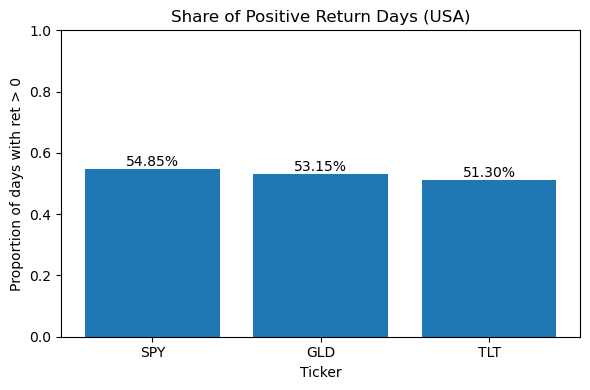

In [24]:
# =========================================
# PUNTO 8 COMPLETO: USA returns + bar chart
# =========================================

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 1) Descargar datos USA
tickers = ["SPY", "TLT", "GLD"]
start = "2015-01-01"
end   = "2025-12-31"

prices = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

# 2) Pasar a formato largo y calcular retornos diarios
usa_returns = (
    prices["Close"]
    .pct_change()
    .reset_index()
    .melt(id_vars="Date", var_name="ticker", value_name="ret")
    .rename(columns={"Date": "date"})
    .dropna()
)

# 3) Calcular share de días con retorno positivo
share_pos = (
    usa_returns
    .assign(pos=lambda x: x["ret"] > 0)
    .groupby("ticker")["pos"]
    .mean()
    .sort_values(ascending=False)
)

# 4) Gráfico de barras con anotaciones
plt.figure(figsize=(6,4))
bars = plt.bar(share_pos.index, share_pos.values)

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{h:.2%}",
        ha="center",
        va="bottom"
    )

plt.title("Share of Positive Return Days (USA)")
plt.ylabel("Proportion of days with ret > 0")
plt.xlabel("Ticker")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


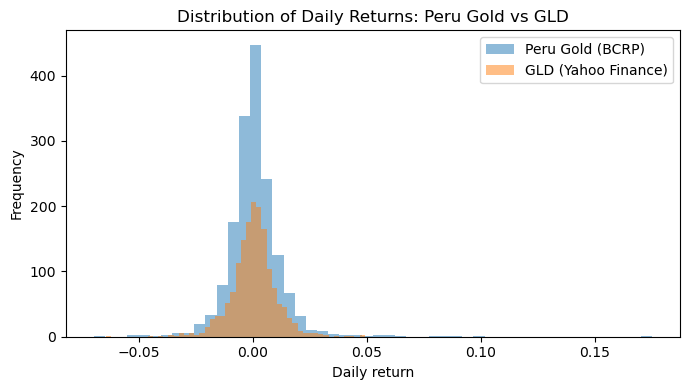

Observaciones comunes: 1615
Std Peru Gold: 0.01237017829712817
Std GLD: 0.009572939582593119


In [28]:
# =========================================
# PUNTO 9: Histogram Peru Gold (BCRP) vs GLD
# (código autónomo y robusto a 'values')
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests

START = "2015-01-01"
END   = "2025-12-31"
BCRP_GOLD_CODE = "PD04704XD"  # Oro Perú (BCRP)

# 1) Descargar Oro Perú (BCRP)
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{BCRP_GOLD_CODE}/json/{START}/{END}"
r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

gold_pe = pd.DataFrame(data["periods"]).rename(columns={"name": "date"})

# el BCRP suele traer 'values' (lista). Tomamos el primer valor.
if "values" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["values"].apply(
        lambda v: v[0] if isinstance(v, list) and len(v) > 0 else np.nan
    )
elif "value" in gold_pe.columns:  # por si acaso viene como 'value'
    gold_pe["gold"] = gold_pe["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value' en periods. Columnas: {gold_pe.columns.tolist()}")

gold_pe["date"] = pd.to_datetime(gold_pe["date"], errors="coerce")
gold_pe["gold"] = pd.to_numeric(gold_pe["gold"], errors="coerce")
gold_pe = gold_pe.dropna(subset=["date", "gold"]).sort_values("date")

gold_pe_ret = gold_pe.set_index("date")["gold"].pct_change().dropna()

# 2) Descargar GLD (Yahoo Finance) y retornos
gld = yf.download("GLD", start=START, end=END, auto_adjust=True, progress=False)
gld_ret = gld["Close"].pct_change().dropna()

# 3) Alinear fechas comunes
common_dates = gold_pe_ret.index.intersection(gld_ret.index)
gold_pe_ret = gold_pe_ret.loc[common_dates]
gld_ret = gld_ret.loc[common_dates]

# 4) Histograma comparativo
plt.figure(figsize=(7,4))
plt.hist(gold_pe_ret, bins=50, alpha=0.5, label="Peru Gold (BCRP)")
plt.hist(gld_ret, bins=50, alpha=0.5, label="GLD (Yahoo Finance)")
plt.title("Distribution of Daily Returns: Peru Gold vs GLD")
plt.xlabel("Daily return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

print("Observaciones comunes:", len(common_dates))
print("Std Peru Gold:", float(gold_pe_ret.std()))
print("Std GLD:", float(gld_ret.std()))


10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


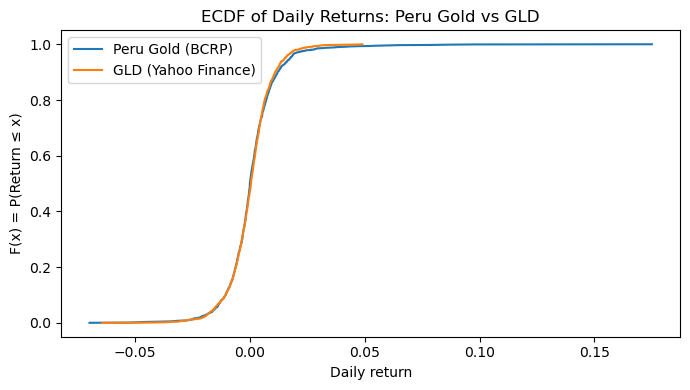

Comentario (ECDF vs Histograma):
- La ECDF NO depende de 'bins' (a diferencia del histograma).
- Permite leer percentiles directamente: por ejemplo, el VaR 95% ≈ percentil 5%.
- Diferencias en colas se ven como separaciones claras en la parte baja (izquierda) de la curva.
Obs comunes: 1615


In [29]:
# =========================================
# PUNTO 10: ECDF Peru Gold (BCRP) vs GLD
# (autónomo + robusto a 'values')
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests

START = "2015-01-01"
END   = "2025-12-31"
BCRP_GOLD_CODE = "PD04704XD"  # Oro Perú (BCRP)

# ---- 1) Descargar Oro Perú (BCRP) y retornos ----
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{BCRP_GOLD_CODE}/json/{START}/{END}"
r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()

gold_pe = pd.DataFrame(data["periods"]).rename(columns={"name":"date"})

if "values" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in gold_pe.columns:
    gold_pe["gold"] = gold_pe["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {gold_pe.columns.tolist()}")

gold_pe["date"] = pd.to_datetime(gold_pe["date"], errors="coerce")
gold_pe["gold"] = pd.to_numeric(gold_pe["gold"], errors="coerce")
gold_pe = gold_pe.dropna(subset=["date","gold"]).sort_values("date")

gold_pe_ret = gold_pe.set_index("date")["gold"].pct_change().dropna()

# ---- 2) Descargar GLD (Yahoo) y retornos ----
gld = yf.download("GLD", start=START, end=END, auto_adjust=True, progress=False)
gld_ret = gld["Close"].pct_change().dropna()

# ---- 3) Alinear fechas ----
common = gold_pe_ret.index.intersection(gld_ret.index)
gold_pe_ret = gold_pe_ret.loc[common]
gld_ret = gld_ret.loc[common]

# ---- 4) ECDF function ----
def ecdf(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    x_sorted = np.sort(x)
    y = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    return x_sorted, y

x_pe, y_pe = ecdf(gold_pe_ret.values)
x_gld, y_gld = ecdf(gld_ret.values)

# ---- 5) Plot ECDF ----
plt.figure(figsize=(7,4))
plt.plot(x_pe, y_pe, label="Peru Gold (BCRP)")
plt.plot(x_gld, y_gld, label="GLD (Yahoo Finance)")
plt.title("ECDF of Daily Returns: Peru Gold vs GLD")
plt.xlabel("Daily return")
plt.ylabel("F(x) = P(Return ≤ x)")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 6) Comentario automático (para tu notebook) ----
print("Comentario (ECDF vs Histograma):")
print("- La ECDF NO depende de 'bins' (a diferencia del histograma).")
print("- Permite leer percentiles directamente: por ejemplo, el VaR 95% ≈ percentil 5%.")
print("- Diferencias en colas se ven como separaciones claras en la parte baja (izquierda) de la curva.")
print("Obs comunes:", len(common))


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


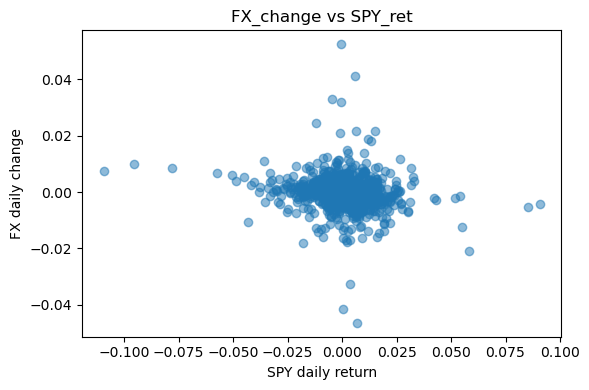

Observaciones usadas: 1554


In [32]:
# =========================================
# PUNTO 11: FX_change (Perú) vs SPY_ret
# Scatter plot (robusto)
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests

START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank
SPY_TICKER = "SPY"

# ---- 1) Descargar FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})

if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v) > 0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date", "fx"]).sort_values("date")

# FX_change = retorno diario del tipo de cambio
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) Descargar SPY (Yahoo Finance) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)

# Extraer Close de forma robusta (Series)
close = spy["Close"]
if isinstance(close, pd.DataFrame):          # por si Close viene como DF
    close = close.iloc[:, 0]                # tomar primera columna

spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"
spy_ret = spy_ret.reset_index()

# ---- 3) Merge por fechas ----
merged = (
    fx[["date", "FX_change"]]
    .merge(spy_ret, on="date", how="inner")
    .dropna()
)

# ---- 4) Scatter plot ----
plt.figure(figsize=(6,4))
plt.scatter(merged["SPY_ret"], merged["FX_change"], alpha=0.5)
plt.title("FX_change vs SPY_ret")
plt.xlabel("SPY daily return")
plt.ylabel("FX daily change")
plt.tight_layout()
plt.show()

print("Observaciones usadas:", len(merged))


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [33]:
# =========================================
# PUNTO 12: Correlation FX_change vs SPY_ret
# (autónomo y robusto)
# =========================================

import pandas as pd
import numpy as np
import yfinance as yf
import requests

START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank (Perú)
SPY_TICKER = "SPY"

# ---- 1) FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date","fx"]).sort_values("date")
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) SPY (Yahoo) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
close = spy["Close"]
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]
spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"

# ---- 3) Merge ----
merged = (
    fx[["date","FX_change"]]
    .merge(spy_ret.reset_index(), on="date", how="inner")
    .dropna()
)

# ---- 4) Correlación ----
corr = merged["FX_change"].corr(merged["SPY_ret"])
print(f"Correlation(FX_change, SPY_ret) = {corr:.4f}")

# ---- 5) Interpretación automática ----
if corr < 0:
    print("Interpretación: correlación NEGATIVA.")
    print("- Cuando SPY sube, el sol tiende a apreciarse (FX_change < 0).")
    print("- Consistente con mayor apetito por riesgo y entradas de capital.")
elif corr > 0:
    print("Interpretación: correlación POSITIVA.")
    print("- Cuando SPY cae, el tipo de cambio tiende a subir (depreciación del sol).")
    print("- Consistente con flight-to-safety.")
else:
    print("Interpretación: correlación cercana a cero (relación lineal débil).")

print("Observaciones usadas:", len(merged))


Correlation(FX_change, SPY_ret) = -0.1643
Interpretación: correlación NEGATIVA.
- Cuando SPY sube, el sol tiende a apreciarse (FX_change < 0).
- Consistente con mayor apetito por riesgo y entradas de capital.
Observaciones usadas: 1554


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [35]:
# =========================================
# PUNTO 13: Regresión FX_change ~ SPY_ret
# (autónomo y robusto)
# =========================================

import pandas as pd
import numpy as np
import yfinance as yf
import requests
import statsmodels.api as sm

START = "2015-01-01"
END   = "2025-12-31"

FX_CODE = "PD04637PD"   # FX Interbank (Perú)
SPY_TICKER = "SPY"

# ---- 1) FX (BCRP) ----
url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
r = requests.get(url_fx, timeout=30)
r.raise_for_status()
obj = r.json()

fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
if "values" in fx.columns:
    fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
elif "value" in fx.columns:
    fx["fx"] = fx["value"]
else:
    raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
fx = fx.dropna(subset=["date","fx"]).sort_values("date")
fx["FX_change"] = fx["fx"].pct_change()

# ---- 2) SPY (Yahoo) ----
spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
close = spy["Close"]
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]
spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
spy_ret.index.name = "date"

# ---- 3) Merge ----
merged = (
    fx[["date","FX_change"]]
    .merge(spy_ret.reset_index(), on="date", how="inner")
    .dropna()
)

# ---- 4) Regresión OLS ----
X = sm.add_constant(merged["SPY_ret"])  # agrega intercepto
y = merged["FX_change"]

model = sm.OLS(y, X).fit()
print(model.summary())

# ---- 5) Interpretación automática del coeficiente ----
beta = model.params["SPY_ret"]
alpha = model.params["const"]

print("\nInterpretación:")
print(f"- Intercepto (alpha): {alpha:.6f}")
print(f"- Pendiente (beta): {beta:.4f}")

if beta < 0:
    print("→ Un aumento de 1% en el SPY se asocia con una APRECIACIÓN del sol (FX_change negativo).")
elif beta > 0:
    print("→ Un aumento de 1% en el SPY se asocia con una DEPRECIACIÓN del sol (FX_change positivo).")
else:
    print("→ No hay relación lineal apreciable.")

print("Observaciones usadas:", len(merged))


                            OLS Regression Results                            
Dep. Variable:              FX_change   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     43.08
Date:                Fri, 09 Jan 2026   Prob (F-statistic):           7.13e-11
Time:                        15:21:12   Log-Likelihood:                 6089.7
No. Observations:                1554   AIC:                        -1.218e+04
Df Residuals:                    1552   BIC:                        -1.216e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      1.029      0.3

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [36]:
# =========================================
# PUNTO 14: Pandas selection
# .iloc (posición) vs conditional filtering (condición)
# =========================================

import pandas as pd
import numpy as np
import yfinance as yf
import requests

# --- Si no existe merged, lo construimos rápido (como en punto 11) ---
if "merged" not in globals() or not isinstance(globals()["merged"], pd.DataFrame):
    START = "2015-01-01"
    END   = "2025-12-31"
    FX_CODE = "PD04637PD"
    SPY_TICKER = "SPY"

    # FX BCRP
    url_fx = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{FX_CODE}/json/{START}/{END}"
    r = requests.get(url_fx, timeout=30)
    r.raise_for_status()
    obj = r.json()

    fx = pd.DataFrame(obj["periods"]).rename(columns={"name": "date"})
    if "values" in fx.columns:
        fx["fx"] = fx["values"].apply(lambda v: v[0] if isinstance(v, list) and len(v)>0 else np.nan)
    elif "value" in fx.columns:
        fx["fx"] = fx["value"]
    else:
        raise KeyError(f"No encuentro 'values' ni 'value'. Columnas: {fx.columns.tolist()}")

    fx["date"] = pd.to_datetime(fx["date"], errors="coerce")
    fx["fx"] = pd.to_numeric(fx["fx"], errors="coerce")
    fx = fx.dropna(subset=["date","fx"]).sort_values("date")
    fx["FX_change"] = fx["fx"].pct_change()

    # SPY Yahoo
    spy = yf.download(SPY_TICKER, start=START, end=END, auto_adjust=True, progress=False)
    close = spy["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    spy_ret = close.pct_change().dropna().to_frame(name="SPY_ret")
    spy_ret.index.name = "date"

    merged = (
        fx[["date","FX_change"]]
        .merge(spy_ret.reset_index(), on="date", how="inner")
        .dropna()
    )

# ----------------------------
# A) .iloc  (posición)
# ----------------------------
print("A) Ejemplo .iloc (por posición): primeras 5 filas y 2 columnas (date y FX_change)")
print(merged.iloc[:5, :2])   # filas 0-4, columnas 0-1

# ----------------------------
# B) Conditional filtering (condición)
# ----------------------------
print("\nB) Ejemplo de filtro condicional: días donde SPY_ret > 2%")
big_spy = merged[merged["SPY_ret"] > 0.02]  # 2% = 0.02
print(big_spy.head())

print("\nCantidad de días con SPY_ret > 2%:", len(big_spy))

# ----------------------------
# Explicación breve
# ----------------------------
print("\nExplicación:")
print("- .iloc selecciona por POSICIÓN (índices numéricos). No le importa el contenido.")
print("- El filtrado condicional selecciona por REGLA (por ejemplo: retornos > 2%).")
print("- En finanzas, el filtro condicional se usa para eventos (colas, shocks), mientras .iloc sirve para slicing/muestreo.")


A) Ejemplo .iloc (por posición): primeras 5 filas y 2 columnas (date y FX_change)
        date  FX_change
1 2015-02-03  -0.000514
2 2015-02-04   0.001355
3 2015-02-05  -0.000233
4 2015-02-06   0.002101
5 2015-02-09  -0.000559

B) Ejemplo de filtro condicional: días donde SPY_ret > 2%
          date  FX_change   SPY_ret
149 2016-02-12  -0.001870  0.020617
160 2016-03-01  -0.000973  0.023507
265 2016-11-07  -0.003336  0.022057
459 2018-03-26  -0.006008  0.027359
533 2018-10-16  -0.001370  0.021866

Cantidad de días con SPY_ret > 2%: 45

Explicación:
- .iloc selecciona por POSICIÓN (índices numéricos). No le importa el contenido.
- El filtrado condicional selecciona por REGLA (por ejemplo: retornos > 2%).
- En finanzas, el filtro condicional se usa para eventos (colas, shocks), mientras .iloc sirve para slicing/muestreo.


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
